## - Embedder Training using Contrastive triplet loss and siamese network
## - Embedder power inc

In [ ]:
import tensorflow as tf
print(" Initializing TPU Strategy")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    strategy = tf.distribute.get_strategy()
    

print(tf.__version__)

E0000 00:00:1762260068.936045      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


Initializing TPU Strategy
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1762260092.588326      10 service.cc:148] XLA service 0x59dfedc88f40 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762260092.588364      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1762260092.588367      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1762260092.588369      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1762260092.588371      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1762260092.588373      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1762260092.588375      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1762260092.588377      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1762260092.588378      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
!pip install faiss-cpu --quiet
import faiss 
from sklearn.metrics import classification_report

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Config
INPUT_DIR = Path("/kaggle/input/w2v-prc/output_wav2vec_custom_augmented")
OUTPUT_DIR = Path("./out_stFold_retrieval")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 16
EPOCHS = 50
LEARNING_RATE = 2e-5
THRESHOLD = 0.3

K_NEIGHBORS = 10
FAISS_INDEX_PATH = OUTPUT_DIR / "train_data.index"

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
BEST_MODEL_PATH = OUTPUT_DIR / "res6.keras"

BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
print(f"Global batch size set to: {BATCH_SIZE}")

Global batch size set to: 128


In [ ]:
print("\nLoading all compressed features")
train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

X_train, y_train_full = train_data['x'], train_data['y']
X_val, y_val_full = val_data['x'], val_data['y']
X_test, y_test_full = test_data['x'], test_data['y']

# removes the last column NoStutter from the labels
y_train = y_train_full[:, :-1]
y_val = y_val_full[:, :-1]
y_test = y_test_full[:, :-1]

train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and filtered successfully.")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


Loading all compressed features
Data loaded and filtered successfully.
Training set shape: (29783, 150, 768)
Validation set shape: (3676, 150, 768)
Test set shape: (3906, 150, 768)


In [ ]:
def build_powerful_embedder(input_shape):
    """
    Builds a more powerful embedder by adding trainable transformation layers
    before the attention pooling.
    """
    sequence_input = layers.Input(shape=input_shape, name="sequence_input")
    
    x = layers.Bidirectional(layers.GRU(256, return_sequences=True))(sequence_input)
    # proj back to original dim
    x = layers.Dense(EMBEDDING_DIM, activation='relu')(x)   
    
    # attention pooling head applied to the transformed features
    scores = layers.Dense(1, activation='tanh', name='attention_scores')(x)
    attention_weights = layers.Softmax(axis=1, name='attention_weights')(scores)
    weighted_sequence = layers.Multiply(name='weighted_sequence')([x, attention_weights])
    pooled_embedding = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted_sequence)
    
    embedder_model = tf.keras.Model(inputs=sequence_input, outputs=pooled_embedding, name="powerful_embedder_model")
    return embedder_model

In [ ]:
# data preparation for triplet training
from scipy.spatial.distance import pdist, squareform
print("\nPre-calculating pairwise Jaccard distances for triplet mining")
jaccard_distances = squareform(pdist(y_train, 'jaccard'))

triplet_lookup = []
for i in range(len(y_train)):
    positives = np.where(jaccard_distances[i] < 0.5)[0]
    positives = positives[positives != i]
    negatives = np.where(jaccard_distances[i] > 0.8)[0]
    if len(positives) > 0 and len(negatives) > 0:
        triplet_lookup.append({
            "anchor_id": i, "positive_ids": positives, "negative_ids": negatives
        })
print(f"Created a triplet lookup for {len(triplet_lookup)} samples with valid pairs.")

def triplet_generator(lookup, X_data):
    anchor_indices = np.arange(len(lookup))
    while True:
        np.random.shuffle(anchor_indices)
        for i in anchor_indices:
            data = lookup[i]
            anchor_idx, positive_idx, negative_idx = data['anchor_id'], np.random.choice(data['positive_ids']), np.random.choice(data['negative_ids'])
            yield (X_data[anchor_idx], X_data[positive_idx], X_data[negative_idx]), 0

EMBEDDER_BATCH_SIZE = 64
train_triplet_ds = tf.data.Dataset.from_generator(
    lambda: triplet_generator(triplet_lookup, X_train),
    output_signature=(
        (tf.TensorSpec(shape=(MAX_SEQ_LEN, EMBEDDING_DIM), dtype=tf.float32),
         tf.TensorSpec(shape=(MAX_SEQ_LEN, EMBEDDING_DIM), dtype=tf.float32),
         tf.TensorSpec(shape=(MAX_SEQ_LEN, EMBEDDING_DIM), dtype=tf.float32)),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(EMBEDDER_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Pre-calculating pairwise Jaccard distances for triplet mining
Created a triplet lookup for 29699 samples with valid pairs.


In [7]:
def triplet_loss(y_true, y_pred, margin=0.4):
    anchor, positive, negative = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
    positive_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    negative_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(0.0, positive_dist - negative_dist + margin)
    return tf.reduce_mean(loss)

In [ ]:
TRIPLET_EMBEDDER_WEIGHTS_PATH = Path("powerful_triplet_embedder_equal_jaccard.weights.h5")

with strategy.scope():
    # core embedder model that will be shared.
    embedder_model = build_powerful_embedder(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM))
    
    # three inputs for the Siamese network
    anchor_input = layers.Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM))
    positive_input = layers.Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM))
    negative_input = layers.Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM))
    
    # processing each input through the same shared embedder model
    anchor_embedding = embedder_model(anchor_input)
    positive_embedding = embedder_model(positive_input)
    negative_embedding = embedder_model(negative_input)
    
    # stacks the outp for loss fn
    stacked_embeddings = layers.Lambda(lambda x: tf.stack(x, axis=1))([anchor_embedding, positive_embedding, negative_embedding])
    
    triplet_model = tf.keras.Model(inputs=[anchor_input, positive_input, negative_input], outputs=stacked_embeddings)
    triplet_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=triplet_loss)

I0000 00:00:1762260308.593020      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [ ]:
from sklearn.metrics import pairwise_distances

class RecallAtKEvaluator(tf.keras.callbacks.Callback):
    def __init__(self, embedder_model, X_val, y_val, k=10):
        super().__init__()
        self.embedder_model = embedder_model
        self.X_val = X_val
        self.y_val = y_val
        self.k = k
        
        # precalc the pairwise similarity of validation labels
        self.val_jaccard_distances = squareform(pdist(self.y_val, 'jaccard'))

    def on_epoch_end(self, epoch, logs=None):
        print(f"\nCalculating Recall@{self.k} on validation set for epoch {epoch+1}")
        
        # gen embeds
        val_embeddings = self.embedder_model.predict(self.X_val, batch_size=512, verbose=0)
        
        faiss.normalize_L2(val_embeddings)
        index = faiss.IndexFlatIP(val_embeddings.shape[1])
        index.add(val_embeddings)
        
        # find its k+1 nearest neighbors (excluding self)
        D, I = index.search(val_embeddings, self.k + 1)
        
        total_relevant_retrieved = 0
        total_possible_positives = 0
        
        # calculate recall@k
        for i in range(len(self.y_val)):
            # the indices of the neighbors, excluding the first one
            retrieved_indices = I[i, 1:]
            
            # jaccard distances between the anchor and the neighbors
            neighbor_jaccard_dists = self.val_jaccard_distances[i, retrieved_indices]
            
            relevant_retrieved_count = np.sum(neighbor_jaccard_dists <= 0.5)
            
            total_relevant_retrieved += relevant_retrieved_count

        # calculate micro-average recall.
        recall_at_k = total_relevant_retrieved / (len(self.y_val) * self.k)
        
        print(f"Validation Recall@{self.k}: {recall_at_k:.4f}")
        logs[f'val_recall_at_{self.k}'] = recall_at_k

In [ ]:
if not TRIPLET_EMBEDDER_WEIGHTS_PATH.exists():
    print("\nTraining embedder with Triplet Loss")
    triplet_model.summary()

    # cust callback
    recall_k_callback = RecallAtKEvaluator(
        embedder_model=embedder_model,
        X_val=X_val,
        y_val=y_val,
        k=K_NEIGHBORS
    )
    
    triplet_model.fit(
        train_triplet_ds, 
        epochs=20,
        steps_per_epoch=len(triplet_lookup) // EMBEDDER_BATCH_SIZE,
        callbacks=[
            recall_k_callback,
            tf.keras.callbacks.EarlyStopping(
                monitor=f'val_recall_at_{K_NEIGHBORS}',
                mode='max', 
                patience=3,
                restore_best_weights=True,
                verbose = 1
            )
        ]
    )

    embedder_model.save_weights(TRIPLET_EMBEDDER_WEIGHTS_PATH)
    print(f"Triplet embedder weights saved to {TRIPLET_EMBEDDER_WEIGHTS_PATH}")
else:
    print(f"\nFound existing triplet embedder weights at {TRIPLET_EMBEDDER_WEIGHTS_PATH}. Loading them.")
    embedder_model.load_weights(TRIPLET_EMBEDDER_WEIGHTS_PATH)


Training embedder with Triplet Loss


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ powerful_embedder_… │ (None, 768)       │  1,970,689 │ input_layer[0][0… │
│ (Functional)        │                   │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 3, 768)    │          0 │ powerful_embedde… │
│                     │                   │            │ powerful_embedde… │
│                     │                   │            │ powerful_embedde… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,970,689 (7.52 MB)

 Trainable params: 1,970,689 (7.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1762260318.726429      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14427123300062481539
I0000 00:00:1762260319.979931    1123 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16311197863680978160), session_name()
I0000 00:00:1762260326.050706    1123 tpu_compile_op_common.cc:245] Compilation of 16311197863680978160 with session name  took 6.070708926s and succeeded
I0000 00:00:1762260326.069469    1123 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16311197863680978160), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_14427123300062481539", property.function_library_fingerprint = 3089158592402187961, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap(

464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 2.9467
Calculating Recall@10 on validation set for epoch 1


I0000 00:00:1762260516.916798      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:17401182697791532893
E0000 00:00:1762260516.937669      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node powerful_embedder_model_1/attention_scores_1/Add/ReadVariableOp.
I0000 00:00:1762260516.988822    1052 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3008512147967427143), session_name()
I0000 00:00:1762260517.675127    1052 tpu_compile_op_common.cc:245] Compilation of 3008512147967427143 with session name  took 686.236673ms and succeeded
I0000 00:00:1762260517.676540    1052 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3008512147967427143), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_17401182697791532893", property.function_library_fingerprint = 4093042845438575438, property.mli

Validation Recall@10: 0.3956
464/464 ━━━━━━━━━━━━━━━━━━━━ 214s 440ms/step - loss: 2.9468 - val_recall_at_10: 0.3956
Epoch 2/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - loss: 2.8647
Calculating Recall@10 on validation set for epoch 2
Validation Recall@10: 0.4054
464/464 ━━━━━━━━━━━━━━━━━━━━ 273s 589ms/step - loss: 2.8647 - val_recall_at_10: 0.4054
Epoch 3/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - loss: 2.7623
Calculating Recall@10 on validation set for epoch 3
Validation Recall@10: 0.4079
464/464 ━━━━━━━━━━━━━━━━━━━━ 345s 743ms/step - loss: 2.7624 - val_recall_at_10: 0.4079
Epoch 4/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - loss: 2.7889
Calculating Recall@10 on validation set for epoch 4
Validation Recall@10: 0.4167
464/464 ━━━━━━━━━━━━━━━━━━━━ 392s 844ms/step - loss: 2.7888 - val_recall_at_10: 0.4167
Epoch 5/20
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - loss: 2.6981
Calculating Recall@10 on validation set for epoch 5
Validation Recall@10: 0.4275
464/464 ━━━━━━━━━━━━━━━

In [ ]:
ATTENTION_FAISS_PATH = OUTPUT_DIR / "train_data_triplet_attention_equal_jaccard.index"

if not ATTENTION_FAISS_PATH.exists():
    print("\nGenerating attention-pooled embeddings for all datasets")
    
    X_train_pooled = embedder_model.predict(X_train, batch_size=512)
    X_val_pooled = embedder_model.predict(X_val, batch_size=512)
    X_test_pooled = embedder_model.predict(X_test, batch_size=512)
    print("All datasets have been processed by the Triplet-trained embedder model.")
    
    print("\nBuilding new attention-based Faiss index")
    faiss.normalize_L2(X_train_pooled)
    attention_index = faiss.IndexFlatIP(EMBEDDING_DIM)
    attention_index.add(X_train_pooled)
    faiss.write_index(attention_index, str(ATTENTION_FAISS_PATH))
    print(f"New index saved to: {ATTENTION_FAISS_PATH}")
else:
    print(f"Found existing attention-based Faiss index at {ATTENTION_FAISS_PATH}.")
    
    print("\nGenerating attention-pooled embeddings for train, val and test sets")
    X_train_pooled = embedder_model.predict(X_train, batch_size=512)
    X_val_pooled = embedder_model.predict(X_val, batch_size=512)
    X_test_pooled = embedder_model.predict(X_test, batch_size=512)


print("Loading the smart Faiss index for the main model.")
faiss_index = faiss.read_index(str(ATTENTION_FAISS_PATH))


Generating attention-pooled embeddings for all datasets
58/59 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

I0000 00:00:1762269724.292688    1055 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9851689185396228550), session_name()
I0000 00:00:1762269725.321446    1055 tpu_compile_op_common.cc:245] Compilation of 9851689185396228550 with session name  took 1.028709917s and succeeded
I0000 00:00:1762269725.323424    1055 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9851689185396228550), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_12783340381026000075", property.function_library_fingerprint = 15173013962986623938, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "11,150,768,;", property.guaranteed_constants_size = 0, embed

59/59 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step
7/8 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

I0000 00:00:1762269766.491621    1076 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13759534661556900366), session_name()
I0000 00:00:1762269767.720433    1076 tpu_compile_op_common.cc:245] Compilation of 13759534661556900366 with session name  took 1.228771338s and succeeded
I0000 00:00:1762269767.722617    1076 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13759534661556900366), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_12783340381026000075", property.function_library_fingerprint = 15173013962986623938, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "41,150,768,;", property.guaranteed_constants_size = 0, em

8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
All datasets have been processed by the Triplet-trained embedder model.

Building new attention-based Faiss index
New index saved to: out_stFold_retrieval/train_data_triplet_attention_equal_jaccard.index
Loading the smart Faiss index for the main model.


In [ ]:
print("\nBuilding simplified retrieval-augmented tf.data pipelines")

def retrieval_generator_precomputed(
    X_source_seqs, y_source_labels, X_source_pooled,
    X_train_retrieval_seqs, y_train_retrieval_labels,
    index, k, is_training=False):
    """
    Generator now uses pre-computed pooled vectors for queries, making it faster and more consistent.
    """
    for i in range(len(X_source_seqs)):
        query_vector = X_source_pooled[i:i+1] # Shape (1, 768)
        
        faiss.normalize_L2(query_vector)
    
        if is_training:
            distances, indices = index.search(query_vector, k + 1)
            distances = distances.squeeze()[1:]
            indices = indices.squeeze()[1:]
        else:
            distances, indices = index.search(query_vector, k)
            distances = distances.squeeze()
            indices = indices.squeeze()
        
        neighbor_seqs = X_train_retrieval_seqs[indices]
        neighbor_labels = y_train_retrieval_labels[indices]
        
        inputs = {
            "input_test_seq": X_source_seqs[i],
            "input_neighbor_seqs": neighbor_seqs,
            "input_neighbor_labels": neighbor_labels.astype('float32'),
            "input_neighbor_sims": distances.astype('float32')
        }
        
        yield inputs, y_source_labels[i].astype('float32')

output_signature = (
    {
        "input_test_seq": tf.TensorSpec(shape=(MAX_SEQ_LEN, EMBEDDING_DIM), dtype=tf.float32),
        "input_neighbor_seqs": tf.TensorSpec(shape=(K_NEIGHBORS, MAX_SEQ_LEN, EMBEDDING_DIM), dtype=tf.float32),
        "input_neighbor_labels": tf.TensorSpec(shape=(K_NEIGHBORS, NUM_CLASSES), dtype=tf.float32),
        "input_neighbor_sims": tf.TensorSpec(shape=(K_NEIGHBORS,), dtype=tf.float32)
    },
    tf.TensorSpec(shape=(NUM_CLASSES,), dtype=tf.float32)
)

# creates the ds using new generator, pre-computed pooled arrays
train_dataset = tf.data.Dataset.from_generator(
    lambda: retrieval_generator_precomputed(
        X_train, y_train, X_train_pooled, X_train, y_train, faiss_index, K_NEIGHBORS, is_training=True
    ),
    output_signature=output_signature
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: retrieval_generator_precomputed(
        X_val, y_val, X_val_pooled, X_train, y_train, faiss_index, K_NEIGHBORS, is_training=False
    ),
    output_signature=output_signature
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: retrieval_generator_precomputed(
        X_test, y_test, X_test_pooled, X_train, y_train, faiss_index, K_NEIGHBORS, is_training=False
    ),
    output_signature=output_signature
)

def prepare_dataset(ds, shuffle=False):
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=1024)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(train_dataset, shuffle=True)
val_dataset = prepare_dataset(val_dataset)
test_dataset = prepare_dataset(test_dataset)

print("Datasets created successfully.")


Building simplified retrieval-augmented tf.data pipelines
Datasets created successfully.


In [ ]:
def conformer_block(x, num_heads=4, ff_dim=128, dropout=0.1):
    x_conv = layers.LayerNormalization()(x)
    x_conv = layers.Conv1D(filters=EMBEDDING_DIM * 2, kernel_size=1, activation="relu")(x_conv)
    x_conv = layers.DepthwiseConv1D(kernel_size=3, padding="same")(x_conv)
    x_conv = layers.BatchNormalization()(x_conv)
    x_conv = layers.Activation("swish")(x_conv)
    x_conv = layers.Conv1D(filters=EMBEDDING_DIM, kernel_size=1, kernel_regularizer=regularizers.l1(5e-5))(x_conv)
    x_conv = layers.Dropout(dropout)(x_conv)
    x = x + x_conv

    x_attn = layers.LayerNormalization()(x)
    x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
    x_attn = layers.Dropout(dropout)(x_attn)
    x = x + x_attn

    x_ff = layers.LayerNormalization()(x)
    x_ff = layers.Dense(ff_dim, activation="swish")(x_ff)
    x_ff = layers.Dropout(dropout)(x_ff)
    x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
    x = x + x_ff
    return x

with strategy.scope():
    print("\nBuilding Retrieval-Augmented StutterFold Model")

    # inps to main model
    input_test_seq = layers.Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM), name="input_test_seq")
    input_neighbor_seqs = layers.Input(shape=(K_NEIGHBORS, MAX_SEQ_LEN, EMBEDDING_DIM), name="input_neighbor_seqs")
    input_neighbor_labels = layers.Input(shape=(K_NEIGHBORS, NUM_CLASSES), name="input_neighbor_labels")
    input_neighbor_sims = layers.Input(shape=(K_NEIGHBORS,), name="input_neighbor_sims")

    # shared encoder
    encoder_input = layers.Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM), name="encoder_input")
    x = conformer_block(encoder_input, num_heads=4, ff_dim=1028, dropout=0.5)
    x = conformer_block(x, num_heads=4, ff_dim=1028, dropout=0.5)
    encoder_output = layers.GlobalAveragePooling1D()(x)
    shared_encoder = tf.keras.Model(inputs=encoder_input, outputs=encoder_output, name="shared_conformer_encoder")

    # process test seq (to get query)
    q_test = shared_encoder(input_test_seq)

    # process neighb seq (to get keys)
    neighbor_encoder_layer = layers.TimeDistributed(shared_encoder, name="neighbor_encoder")
    k_neighbors = neighbor_encoder_layer(input_neighbor_seqs)

    # prep the vals
    processed_labels = layers.Dense(16, activation='relu', name="label_embedder")(input_neighbor_labels)
    processed_sims = layers.Reshape((K_NEIGHBORS, 1), name="sim_expander")(input_neighbor_sims)
    v_neighbors = layers.Concatenate(name="value_concatenation")([
        k_neighbors,
        processed_labels,
        processed_sims
    ])

    # cross-attn
    query_for_attention = layers.Reshape((1, EMBEDDING_DIM))(q_test)

    attention_output = layers.MultiHeadAttention(
        num_heads=4, key_dim=EMBEDDING_DIM // 4, name="cross_attention"
    )(query=query_for_attention, key=k_neighbors, value=v_neighbors)
    
    context_vector = layers.Reshape((attention_output.shape[-1],))(attention_output)

    # final classifier head
    final_representation = layers.Concatenate()([q_test, context_vector])
    
    x = layers.Dense(512, activation='relu')(final_representation)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(NUM_CLASSES, activation='sigmoid', name="output")(x)

    model = tf.keras.Model(
        inputs={
            "input_test_seq": input_test_seq,
            "input_neighbor_seqs": input_neighbor_seqs,
            "input_neighbor_labels": input_neighbor_labels,
            "input_neighbor_sims": input_neighbor_sims
        },
        outputs=outputs
    )

    optimizer = tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=5e-4)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc_roc'), tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
    )

model.summary()


Building Retrieval-Augmented StutterFold Model


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_test_seq      │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_neighbor_seqs │ (None, 10, 150,   │          0 │ -                 │
│ (InputLayer)        │ 768)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_neighbor_lab… │ (None, 10, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_neighbor_sims │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_conformer_e… │ (None, 768)       │ 12,643,336 │ input_test_seq[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neighbor_encoder    │ (None, 10, 768)   │ 12,643,336 │ input_neighbor_s… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedder      │ (None, 10, 16)    │         96 │ input_neighbor_l… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sim_expander        │ (None, 10, 1)     │          0 │ input_neighbor_s… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 768)    │          0 │ shared_conformer… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ value_concatenation │ (None, 10, 785)   │          0 │ neighbor_encoder… │
│ (Concatenate)       │                   │            │ label_embedder[0… │
│                     │                   │            │ sim_expander[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attention     │ (None, 1, 768)    │  2,375,424 │ neighbor_encoder… │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0],    │
│                     │                   │            │ value_concatenat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 768)       │          0 │ cross_attention[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1536)      │          0 │ shared_conformer… │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │    786,944 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 512)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    131,328 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 5)         │      1,285 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,938,413 (60.80 MB)

 Trainable params: 15,932,269 (60.78 MB)

 Non-trainable params: 6,144 (24.00 KB)

In [ ]:
print("\nStarting Training")

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc_roc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', mode='max', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


Starting Training
Epoch 1/50


I0000 00:00:1762269813.661575      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:10830208830317984841
I0000 00:00:1762269817.186651    1078 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(6918274348075481898), session_name()
I0000 00:00:1762269996.102768    1078 tpu_compile_op_common.cc:245] Compilation of 6918274348075481898 with session name  took 2m58.916079634s and succeeded
I0000 00:00:1762269996.397835    1078 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(6918274348075481898), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_10830208830317984841", property.function_library_fingerprint = 14694507119582267214, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap

    232/Unknown 507s 1s/step - accuracy: 0.2711 - auc_pr: 0.4659 - auc_roc: 0.6138 - loss: 3.5718 - precision: 0.5238 - recall: 0.2427

I0000 00:00:1762270309.705554   13220 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.
/usr/local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
I0000 00:00:1762270316.397588      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:16433857649161442095
I0000 00:00:1762270317.138605    1111 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2109527126448747519), session_name()
I0000 00:00:1762270335.507785    1111 tpu_compile_op_common.cc:245] Compilation of 2109527126448747519 with session name  took 18.369137014s and succeeded
I0000 00:00:1762270335.545588    1111 tpu_compilation


Epoch 1: val_auc_roc improved from -inf to 0.69149, saving model to out_stFold_retrieval/res6.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.2711 - auc_pr: 0.4660 - auc_roc: 0.6139 - loss: 3.5714 - precision: 0.5240 - recall: 0.2428 - val_accuracy: 0.1886 - val_auc_pr: 0.6169 - val_auc_roc: 0.6915 - val_loss: 3.2786 - val_precision: 0.6092 - val_recall: 0.3935
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3163 - auc_pr: 0.5794 - auc_roc: 0.6947 - loss: 3.1724 - precision: 0.6057 - recall: 0.3592

I0000 00:00:1762270839.246080   13948 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.



Epoch 2: val_auc_roc improved from 0.69149 to 0.73297, saving model to out_stFold_retrieval/res6.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - accuracy: 0.3164 - auc_pr: 0.5796 - auc_roc: 0.6949 - loss: 3.1720 - precision: 0.6058 - recall: 0.3593 - val_accuracy: 0.2709 - val_auc_pr: 0.6667 - val_auc_roc: 0.7330 - val_loss: 2.9362 - val_precision: 0.6396 - val_recall: 0.4860
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3651 - auc_pr: 0.6366 - auc_roc: 0.7464 - loss: 2.8097 - precision: 0.6502 - recall: 0.4539

I0000 00:00:1762271393.206074   14585 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.



Epoch 3: val_auc_roc improved from 0.73297 to 0.75490, saving model to out_stFold_retrieval/res6.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.3653 - auc_pr: 0.6367 - auc_roc: 0.7465 - loss: 2.8094 - precision: 0.6503 - recall: 0.4540 - val_accuracy: 0.3119 - val_auc_pr: 0.6909 - val_auc_roc: 0.7549 - val_loss: 2.6202 - val_precision: 0.6565 - val_recall: 0.5317
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4527 - auc_pr: 0.7032 - auc_roc: 0.7920 - loss: 2.4847 - precision: 0.6980 - recall: 0.5155

I0000 00:00:1762271976.640963   15226 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.



Epoch 4: val_auc_roc improved from 0.75490 to 0.76002, saving model to out_stFold_retrieval/res6.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - accuracy: 0.4526 - auc_pr: 0.7033 - auc_roc: 0.7919 - loss: 2.4844 - precision: 0.6980 - recall: 0.5155 - val_accuracy: 0.3192 - val_auc_pr: 0.6963 - val_auc_roc: 0.7600 - val_loss: 2.3428 - val_precision: 0.6619 - val_recall: 0.5403
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4237 - auc_pr: 0.7042 - auc_roc: 0.7902 - loss: 2.2247 - precision: 0.6963 - recall: 0.5131

I0000 00:00:1762272545.260946   15925 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.



Epoch 5: val_auc_roc did not improve from 0.76002
232/232 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - accuracy: 0.4238 - auc_pr: 0.7043 - auc_roc: 0.7903 - loss: 2.2244 - precision: 0.6963 - recall: 0.5132 - val_accuracy: 0.3066 - val_auc_pr: 0.6917 - val_auc_roc: 0.7556 - val_loss: 2.1041 - val_precision: 0.6633 - val_recall: 0.5226
Epoch 6/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4402 - auc_pr: 0.7195 - auc_roc: 0.8071 - loss: 1.9796 - precision: 0.6970 - recall: 0.5458

I0000 00:00:1762273117.575668   16563 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.



Epoch 6: val_auc_roc improved from 0.76002 to 0.76695, saving model to out_stFold_retrieval/res6.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 576s 2s/step - accuracy: 0.4403 - auc_pr: 0.7196 - auc_roc: 0.8072 - loss: 1.9793 - precision: 0.6971 - recall: 0.5458 - val_accuracy: 0.3401 - val_auc_pr: 0.7040 - val_auc_roc: 0.7669 - val_loss: 1.8843 - val_precision: 0.6590 - val_recall: 0.5559
Epoch 7/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4539 - auc_pr: 0.7316 - auc_roc: 0.8138 - loss: 1.7693 - precision: 0.7124 - recall: 0.5514

I0000 00:00:1762273683.191029   17195 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.



Epoch 7: val_auc_roc did not improve from 0.76695
232/232 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.4540 - auc_pr: 0.7317 - auc_roc: 0.8138 - loss: 1.7691 - precision: 0.7125 - recall: 0.5515 - val_accuracy: 0.3267 - val_auc_pr: 0.6972 - val_auc_roc: 0.7604 - val_loss: 1.7009 - val_precision: 0.6637 - val_recall: 0.5400
Epoch 8/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4756 - auc_pr: 0.7424 - auc_roc: 0.8184 - loss: 1.5825 - precision: 0.7172 - recall: 0.5674

I0000 00:00:1762274226.880983   17810 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.



Epoch 8: val_auc_roc did not improve from 0.76695
232/232 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.4755 - auc_pr: 0.7425 - auc_roc: 0.8184 - loss: 1.5823 - precision: 0.7173 - recall: 0.5675 - val_accuracy: 0.3262 - val_auc_pr: 0.7035 - val_auc_roc: 0.7655 - val_loss: 1.5420 - val_precision: 0.6764 - val_recall: 0.5259
Epoch 9/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4636 - auc_pr: 0.7387 - auc_roc: 0.8227 - loss: 1.4192 - precision: 0.7143 - recall: 0.5858

I0000 00:00:1762274787.804634   18457 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.



Epoch 9: val_auc_roc did not improve from 0.76695
232/232 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.4636 - auc_pr: 0.7388 - auc_roc: 0.8228 - loss: 1.4190 - precision: 0.7144 - recall: 0.5859 - val_accuracy: 0.3111 - val_auc_pr: 0.6927 - val_auc_roc: 0.7564 - val_loss: 1.4041 - val_precision: 0.6534 - val_recall: 0.5527
Epoch 10/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4710 - auc_pr: 0.7579 - auc_roc: 0.8279 - loss: 1.2784 - precision: 0.7328 - recall: 0.5810
Epoch 10: val_auc_roc did not improve from 0.76695
232/232 ━━━━━━━━━━━━━━━━━━━━ 595s 3s/step - accuracy: 0.4710 - auc_pr: 0.7579 - auc_roc: 0.8280 - loss: 1.2783 - precision: 0.7328 - recall: 0.5811 - val_accuracy: 0.3239 - val_auc_pr: 0.6921 - val_auc_roc: 0.7575 - val_loss: 1.2854 - val_precision: 0.6518 - val_recall: 0.5610
Epoch 11/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4792 - auc_pr: 0.7663 - auc_roc: 0.8351 - loss: 1.1572 - precision: 0.7325 - recall: 0.5889

I0000 00:00:1762275949.920003   19737 tpu_compile_op_common.cc:108] TpuCompileOp was cancelled. Sleeping for 300 seconds to give time for TPUCompileOp to finished.



Epoch 11: val_auc_roc did not improve from 0.76695
232/232 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.4792 - auc_pr: 0.7664 - auc_roc: 0.8351 - loss: 1.1571 - precision: 0.7325 - recall: 0.5890 - val_accuracy: 0.3546 - val_auc_pr: 0.6919 - val_auc_roc: 0.7580 - val_loss: 1.1840 - val_precision: 0.6600 - val_recall: 0.5482
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.



Evaluating Model on the Test Set
     30/Unknown 47s 2s/step

/usr/local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step

Classification Report (5 Stuttering Classes)
              precision    recall  f1-score   support

Prolongation       0.53      0.71      0.61      1335
       Block       0.55      0.90      0.69      1982
    SoundRep       0.41      0.70      0.52       886
     WordRep       0.51      0.45      0.48       917
Interjection       0.69      0.84      0.76      1833

   micro avg       0.56      0.76      0.64      6953
   macro avg       0.54      0.72      0.61      6953
weighted avg       0.56      0.76      0.64      6953
 samples avg       0.58      0.79      0.63      6953


Generating plots for model training history...


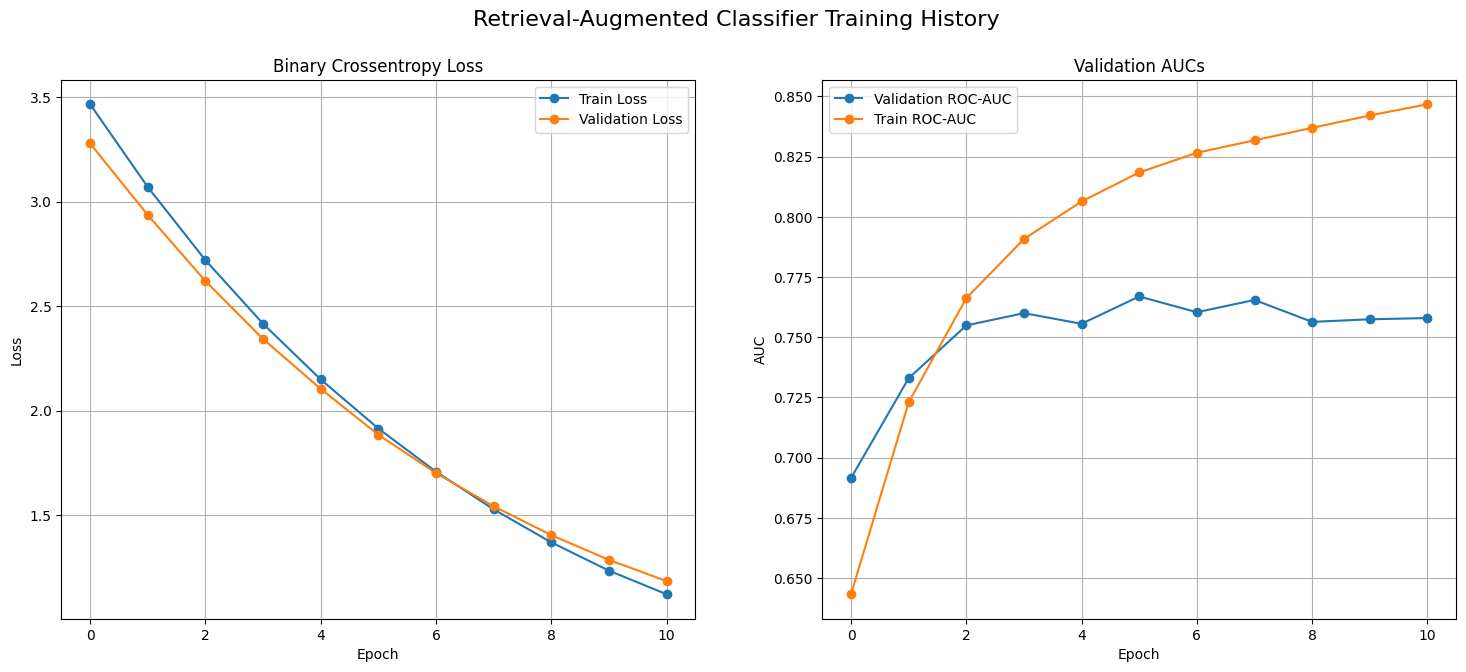


Full pipeline complete.


In [ ]:
print("\nEvaluating Model on the Test Set")

model.load_weights(BEST_MODEL_PATH)

y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions * BATCH_SIZE]

y_test_eval_list = []
for _, labels in test_dataset.unbatch().as_numpy_iterator():
    y_test_eval_list.append(labels)
y_test_eval = np.array(y_test_eval_list)

print("\nClassification Report (5 Stuttering Classes)")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report_retrieval.txt", "w") as f:
    f.write(report)

print("\nGenerating plots for model training history...")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Retrieval-Augmented Classifier Training History', fontsize=16)

ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.plot(history_dict['auc_roc'], 'o-', label='Train ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)

plt.savefig(OUTPUT_DIR / "training_history_retrieval.png")
plt.show()

print("\nFull pipeline complete.")

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------------------------